# Automated Test Log Analysis System
### Interactive Walkthrough

Step through each stage of the semiconductor test log analysis pipeline.  
Run each cell with **Shift+Enter** to see results and visualizations inline.

In [4]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 120
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)

PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
sys.path.insert(0, PROJECT_ROOT)

from src import generate_logs, data_processing, error_extraction
from src import pattern_detection, anomaly_detection, trend_analysis

print('All modules loaded.')

All modules loaded.


---
## Step 1: Generate Simulated Test Logs

Creates **55,000+** test records across **10,000 devices**, **25 batches**, and **8 test types**.  
Includes controlled anomalies: Batch 17 has ~4x failure rate, failures increase above 80°C.

In [5]:
data_path = os.path.join(PROJECT_ROOT, 'data', 'test_logs.csv')
generate_logs.generate(data_path)

# Preview raw data
raw = pd.read_csv(data_path, nrows=10)
display(Markdown('### Raw Data Preview (first 10 rows)'))
display(raw)

Generated 54,803 test records → /Users/york/Automated Test Log Analysis System/data/test_logs.csv


### Raw Data Preview (first 10 rows)

,Timestamp,Device_ID,Batch_ID,Test_Name,Voltage,Temperature,Frequency,Result,Error_Code,Execution_Time
0,2025-02-12 04:26:45,DEV_024_0294,Batch_24,Data_Integrity,1.116,85.7,1.99,PASS,NaN,189.6
1,2025-02-05 12:54:38,DEV_021_0024,Batch_21,Burn_In,1.048,58.8,2.49,PASS,NaN,159.8
2,2025-02-08 03:59:26,DEV_008_0112,Batch_08,Voltage_Sweep,0.993,64.8,2.41,PASS,NaN,190.1
3,2025-03-01 08:43:34,DEV_021_0211,Batch_21,Power_Cycle,1.205,79.5,2.66,PASS,NaN,119.7
4,2025-03-02 03:52:33,DEV_016_0335,Batch_16,Burn_In,1.045,46.5,2.27,PASS,NaN,172.2
5,2025-02-20 01:49:20,DEV_023_0063,Batch_23,Frequency_Scan,1.267,80.5,2.48,PASS,NaN,158.1
6,2025-02-15 07:13:30,DEV_004_0129,Batch_04,Data_Integrity,1.121,76.0,2.44,PASS,NaN,175.8
7,2025-03-09 20:47:10,DEV_003_0103,Batch_03,Voltage_Sweep,1.297,68.4,2.15,PASS,NaN,166.9
8,2025-02-13 03:27:45,DEV_022_0020,Batch_22,Leakage_Test,1.252,74.5,2.08,PASS,NaN,223.0
9,2025-03-28 03:46:04,DEV_012_0200,Batch_12,Power_Cycle,1.002,76.1,2.84,PASS,NaN,84.9


---
## Step 2: Data Processing & Cleaning

Handles messy engineering data:
- Converts numeric columns (coerces invalid values to NaN)
- Removes out-of-range readings (e.g. Temperature = -999)
- Drops rows with missing critical values
- Parses timestamps, standardizes result column

In [6]:
df, cleaning_report = data_processing.process(data_path)

display(Markdown('### Cleaning Report'))
for key, val in cleaning_report.items():
    print(f'  {key:<30} : {val:,}')

display(Markdown('### Clean Data Sample'))
display(df.head(10))

display(Markdown('### Data Types'))
display(df.dtypes)

Loaded 54,803 raw records from /Users/york/Automated Test Log Analysis System/data/test_logs.csv
Cleaning complete: 436 rows removed, 54,367 rows remaining


### Cleaning Report

  rows_with_missing_values       : 206
  rows_out_of_range              : 230
  rows_bad_timestamp             : 0
  rows_invalid_result            : 0
  rows_removed                   : 436
  rows_remaining                 : 54,367


### Clean Data Sample

,Timestamp,Device_ID,Batch_ID,Test_Name,Voltage,Temperature,Frequency,Result,Error_Code,Execution_Time
0,2025-01-01 06:00:39,DEV_008_0358,Batch_08,Frequency_Scan,0.958,73.0,2.43,PASS,,107.1
1,2025-01-01 06:01:58,DEV_021_0398,Batch_21,Voltage_Sweep,0.779,57.7,2.09,PASS,,145.0
2,2025-01-01 06:02:59,DEV_011_0263,Batch_11,Frequency_Scan,1.054,88.4,2.39,FAIL,ERR_F01,126.2
3,2025-01-01 06:03:59,DEV_020_0044,Batch_20,Leakage_Test,0.812,80.5,2.90,PASS,,158.4
4,2025-01-01 06:04:08,DEV_004_0394,Batch_04,Stress_Test,0.912,79.3,2.00,PASS,,143.3
5,2025-01-01 06:04:13,DEV_013_0378,Batch_13,Timing_Check,1.196,62.3,2.71,PASS,,140.8
6,2025-01-01 06:08:19,DEV_004_0056,Batch_04,Power_Cycle,0.862,76.8,2.79,PASS,,93.6
7,2025-01-01 06:09:14,DEV_003_0221,Batch_03,Timing_Check,1.164,75.2,2.40,PASS,,119.9
8,2025-01-01 06:09:42,DEV_004_0304,Batch_04,Leakage_Test,1.236,72.9,3.10,PASS,,97.3
9,2025-01-01 06:16:48,DEV_025_0258,Batch_25,Data_Integrity,1.226,96.3,2.13,PASS,,119.4


### Data Types

Timestamp         datetime64[ns]
Device_ID                 object
Batch_ID                  object
Test_Name                 object
Voltage                  float64
Temperature              float64
Frequency                float64
Result                    object
Error_Code                object
Execution_Time           float64
dtype: object

---
## Step 3: Error Extraction & Failure Classification

Filters all FAIL results, maps each error code to one of 4 categories:
- **Timing Failure** — clock/setup/hold violations
- **Overcurrent** — voltage/leakage anomalies
- **Data Corruption** — integrity check failures
- **Thermal Issue** — burn-in/stress thermal events

In [9]:
failures, err_summary, cat_summary = error_extraction.analyze(df)

display(Markdown('### Error Code Summary'))
display(err_summary)

display(Markdown('### Failure Category Breakdown'))
display(cat_summary)

Extracted 1,586 failure records out of 54,367 total


### Error Code Summary

,Error_Code,Test_Name,Failure_Category,Count,Avg_Temperature,Avg_Voltage,Avg_Execution_Time
15,ERR_T03,Timing_Check,Timing Failure,108,69.7,1.044,151.0
14,ERR_T02,Timing_Check,Timing Failure,106,71.5,1.065,151.8
6,ERR_F02,Frequency_Scan,Overcurrent,105,72.3,1.043,152.6
17,ERR_V02,Voltage_Sweep,Overcurrent,97,67.4,1.035,155.0
12,ERR_S02,Stress_Test,Data Corruption,93,66.7,1.039,151.3
8,ERR_L02,Leakage_Test,Thermal Issue,92,68.0,1.046,154.2
0,ERR_B01,Burn_In,Thermal Issue,90,69.0,1.054,147.5
3,ERR_D01,Data_Integrity,Data Corruption,90,73.5,1.072,160.0
16,ERR_V01,Voltage_Sweep,Overcurrent,89,71.7,1.042,146.8
5,ERR_F01,Frequency_Scan,Timing Failure,88,72.8,1.046,149.0


### Failure Category Breakdown

,Failure_Category,Count,Unique_Error_Codes,Avg_Temperature,Avg_Voltage
1,Overcurrent,453,5,70.4,1.039
0,Data Corruption,416,5,69.5,1.054
3,Timing Failure,378,4,71.3,1.051
2,Thermal Issue,339,4,70.1,1.047


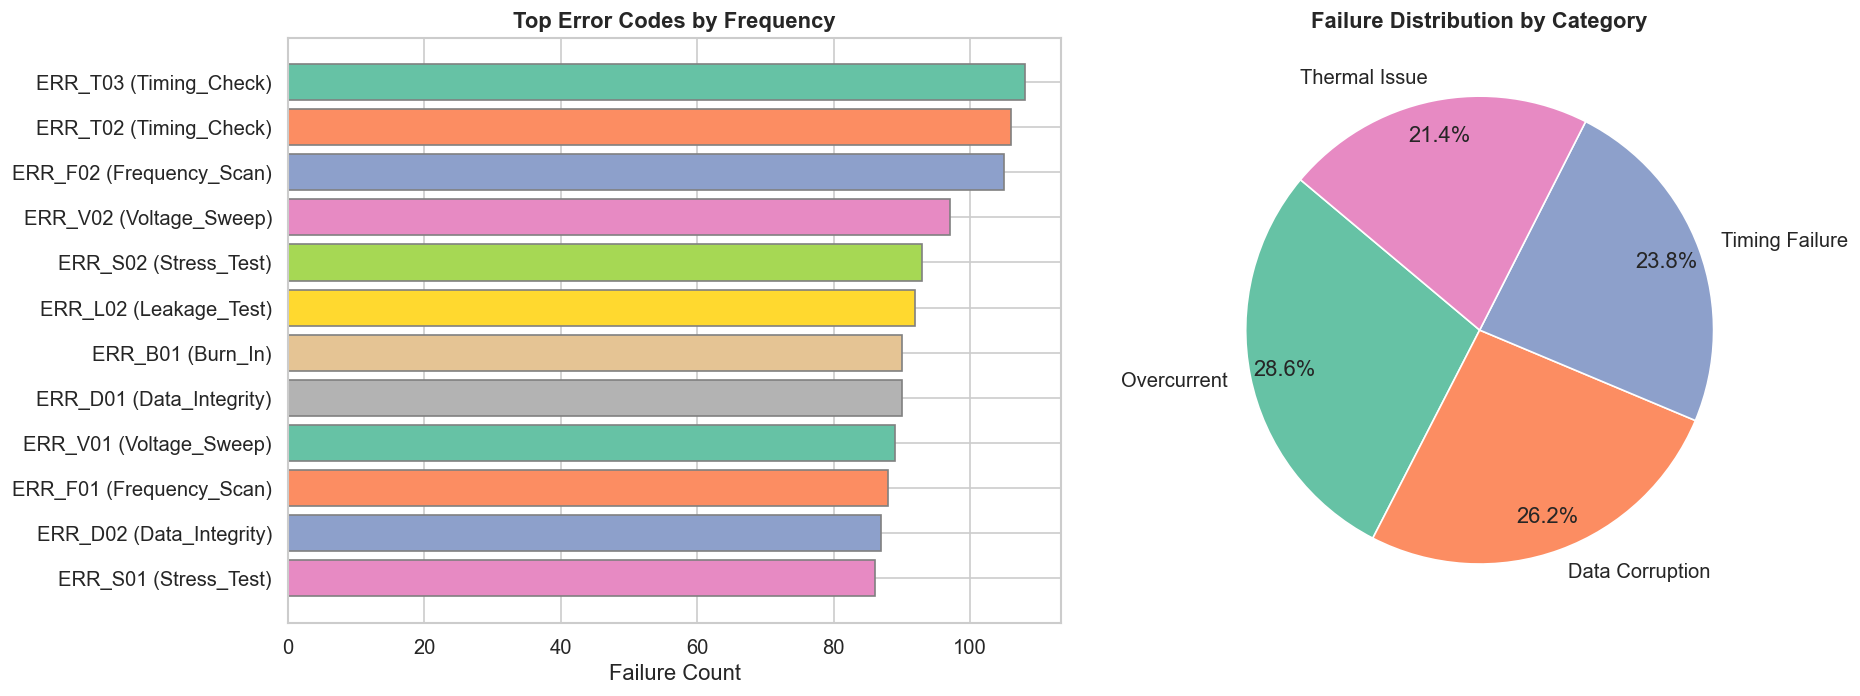

In [10]:
# Visualize: Error code frequency
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

top = err_summary.head(12)
axes[0].barh(top['Error_Code'] + ' (' + top['Test_Name'] + ')', top['Count'],
             color=sns.color_palette('Set2', len(top)), edgecolor='gray')
axes[0].set_xlabel('Failure Count')
axes[0].set_title('Top Error Codes by Frequency', fontweight='bold')
axes[0].invert_yaxis()

# Visualize: Failure categories pie
axes[1].pie(cat_summary['Count'], labels=cat_summary['Failure_Category'],
            autopct='%1.1f%%', colors=sns.color_palette('Set2', len(cat_summary)),
            startangle=140, pctdistance=0.85)
axes[1].set_title('Failure Distribution by Category', fontweight='bold')

plt.tight_layout()
plt.show()

---
## Step 4: Pattern Detection & Correlation Analysis

Looks for relationships between failures and environmental conditions:  
temperature, voltage, batch, test type, and execution duration.

In [11]:
patterns = pattern_detection.analyze(df)

display(Markdown('### Feature Correlations with Failure'))
display(patterns['correlations'])

Pattern detection complete: analyzed 5 dimensions + correlations


/Users/york/Automated Test Log Analysis System/src/pattern_detection.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = work.groupby(group_col)["Result"].agg(
/Users/york/Automated Test Log Analysis System/src/pattern_detection.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = work.groupby(group_col)["Result"].agg(
/Users/york/Automated Test Log Analysis System/src/pattern_detection.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

### Feature Correlations with Failure

,Feature,Correlation,P_Value,Significant,Strength
0,Temperature,0.0513,4.970384e-33,True,Weak
1,Voltage,-0.0039,3.693079e-01,False,Weak
2,Frequency,-0.0034,4.323667e-01,False,Weak
3,Execution_Time,0.0050,2.416828e-01,False,Weak


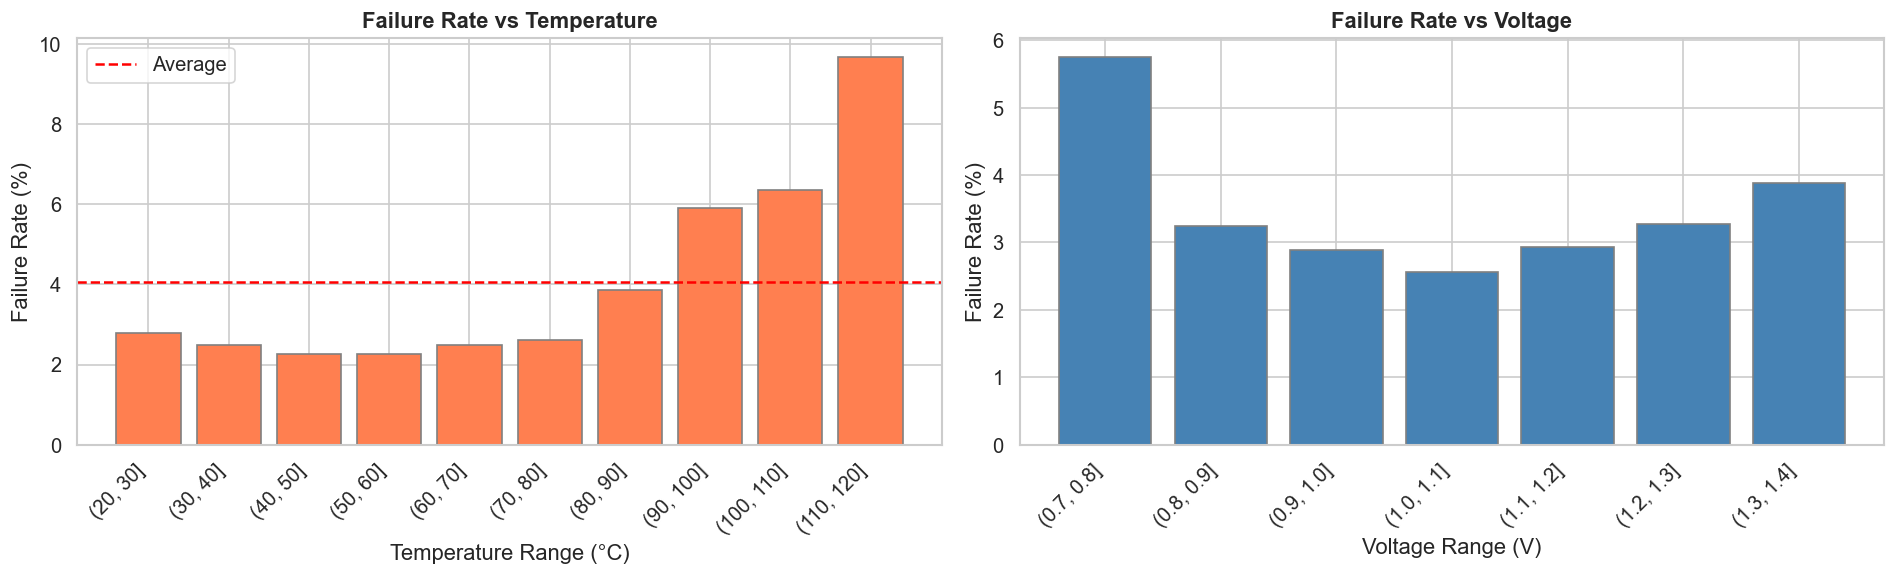

In [12]:
# Failure rate vs Temperature
temp = patterns['failure_vs_temperature']
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].bar(temp['Temperature_bin'].astype(str), temp['Failure_Rate_Pct'],
            color='coral', edgecolor='gray')
axes[0].axhline(y=temp['Failure_Rate_Pct'].mean(), color='red',
                linestyle='--', label='Average')
axes[0].set_xlabel('Temperature Range (°C)')
axes[0].set_ylabel('Failure Rate (%)')
axes[0].set_title('Failure Rate vs Temperature', fontweight='bold')
axes[0].legend()
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Failure rate vs Voltage
volt = patterns['failure_vs_voltage']
axes[1].bar(volt['Voltage_bin'].astype(str), volt['Failure_Rate_Pct'],
            color='steelblue', edgecolor='gray')
axes[1].set_xlabel('Voltage Range (V)')
axes[1].set_ylabel('Failure Rate (%)')
axes[1].set_title('Failure Rate vs Voltage', fontweight='bold')
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

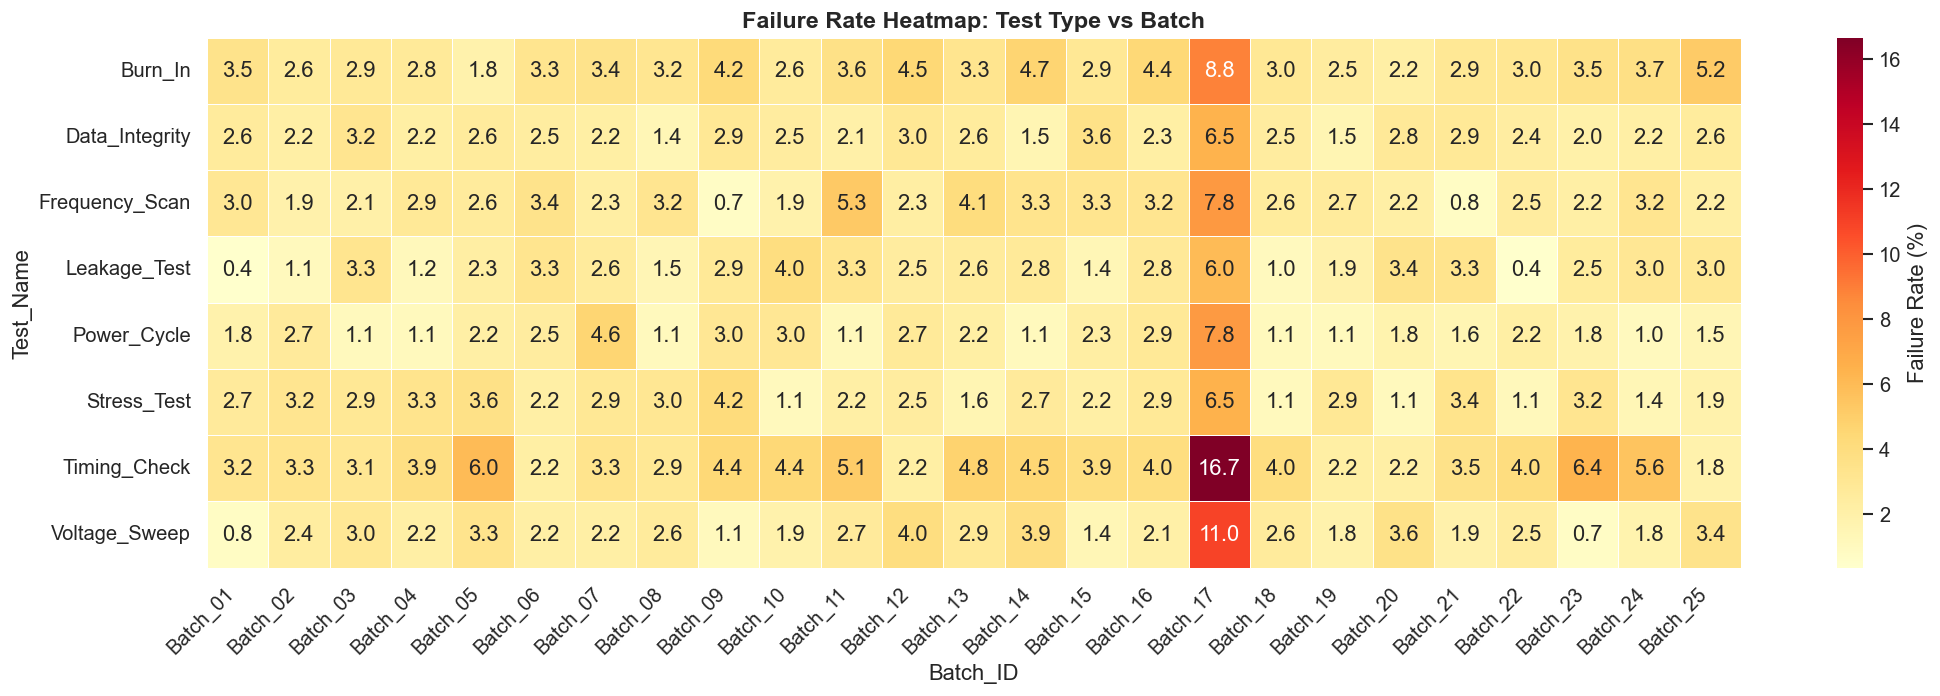

In [13]:
# Failure heatmap: Test Type x Batch
pivot = df.pivot_table(index='Test_Name', columns='Batch_ID',
                       values='Result',
                       aggfunc=lambda x: (x == 'FAIL').mean() * 100)

fig, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, cbar_kws={'label': 'Failure Rate (%)'})
ax.set_title('Failure Rate Heatmap: Test Type vs Batch', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## Step 5: Anomaly Detection

Uses statistical methods to flag unusual behavior:
- **Z-score** on batch failure rates → anomalous production lots
- **Moving average + bounds** on daily failures → error spikes
- **Z-score** on per-device failure rates → outlier devices

In [14]:
anomaly_results = anomaly_detection.analyze(df, failures)

display(Markdown('### Anomalous Batches'))
display(anomaly_results['anomalous_batches'])

display(Markdown(f"### Outlier Devices: {len(anomaly_results['outlier_devices'])} found"))
display(anomaly_results['outlier_devices'].head(10))

Batch anomaly detection: 1 anomalous batch(es) found
Error spike detection: 0 spike day(s) found
Outlier device detection: 231 outlier device(s) found


### Anomalous Batches

,Batch_ID,Total,Failures,Failure_Rate,Z_Score,Is_Anomaly,Failure_Rate_Pct
0,Batch_17,2201,194,0.088142,4.658,True,8.81


### Outlier Devices: 231 found

,Device_ID,Total,Failures,Failure_Rate,Z_Score,Is_Outlier
0,DEV_017_0283,4,3,0.750000,9.249,True
1,DEV_011_0290,3,2,0.666667,8.179,True
2,DEV_022_0243,3,2,0.666667,8.179,True
3,DEV_015_0049,3,2,0.666667,8.179,True
4,DEV_015_0067,3,2,0.666667,8.179,True
5,DEV_017_0298,3,2,0.666667,8.179,True
6,DEV_004_0175,3,2,0.666667,8.179,True
7,DEV_017_0332,3,2,0.666667,8.179,True
8,DEV_011_0348,3,2,0.666667,8.179,True
9,DEV_008_0393,3,2,0.666667,8.179,True


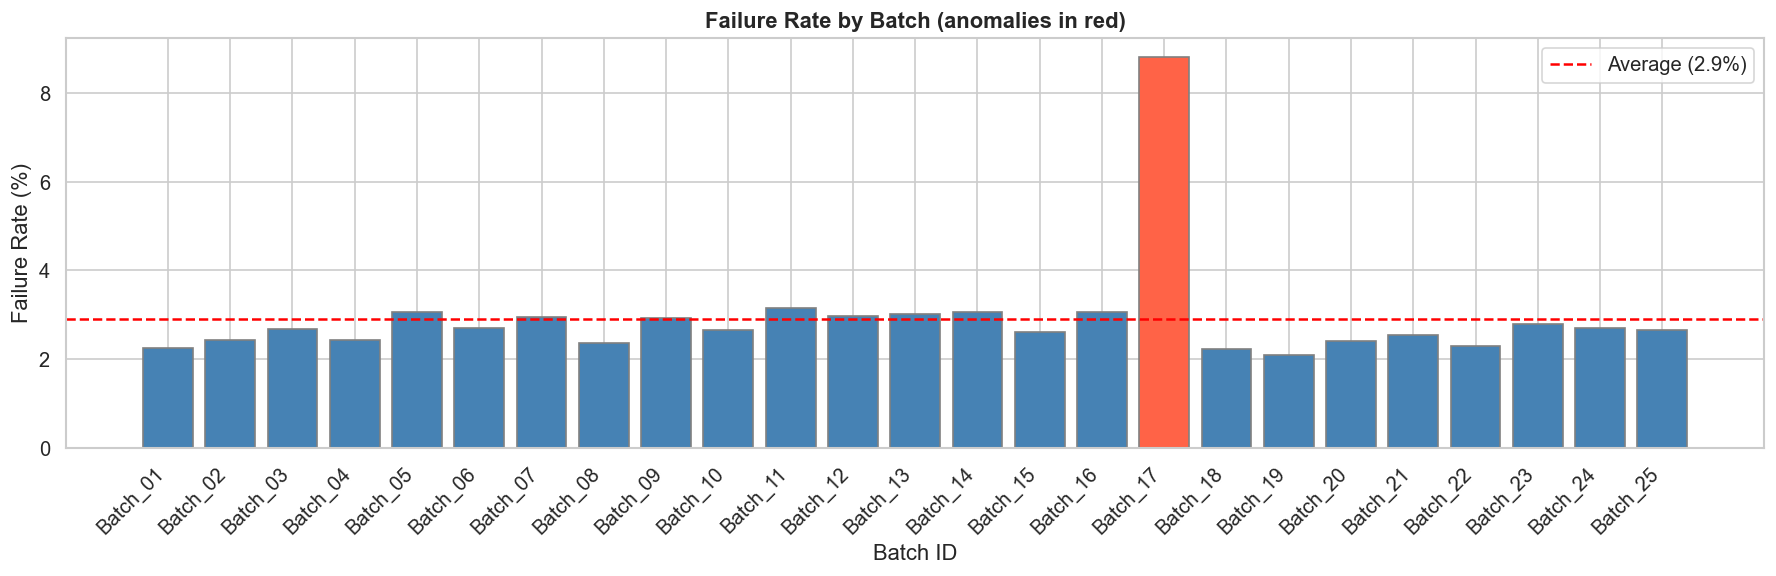

In [15]:
# Batch failure rate with anomaly highlighting
batch = patterns['failure_vs_batch']
mean_rate = batch['Failure_Rate_Pct'].mean()

colors = ['tomato' if r > mean_rate * 2 else 'steelblue'
          for r in batch['Failure_Rate_Pct']]

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(batch['Batch_ID'], batch['Failure_Rate_Pct'], color=colors, edgecolor='gray')
ax.axhline(y=mean_rate, color='red', linestyle='--',
           label=f'Average ({mean_rate:.1f}%)')
ax.set_xlabel('Batch ID')
ax.set_ylabel('Failure Rate (%)')
ax.set_title('Failure Rate by Batch (anomalies in red)', fontweight='bold')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

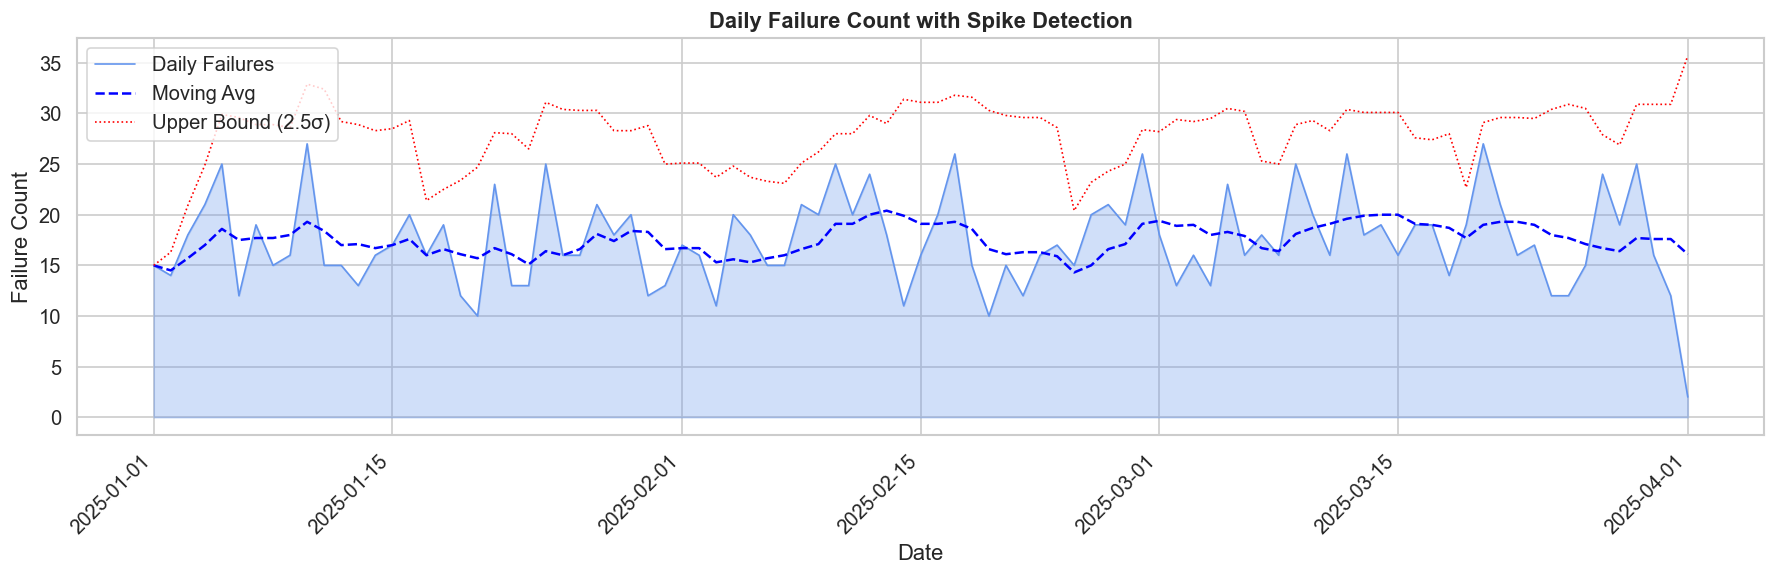

In [16]:
# Error spike timeline
spike_data = anomaly_results['spike_data']

fig, ax = plt.subplots(figsize=(15, 5))
ax.fill_between(spike_data.index, spike_data['Daily_Failures'], alpha=0.3, color='cornflowerblue')
ax.plot(spike_data.index, spike_data['Daily_Failures'], color='cornflowerblue',
        linewidth=1, label='Daily Failures')
ax.plot(spike_data.index, spike_data['Moving_Avg'], color='blue',
        linestyle='--', linewidth=1.5, label='Moving Avg')
ax.plot(spike_data.index, spike_data['Upper_Bound'], color='red',
        linestyle=':', linewidth=1, label='Upper Bound (2.5σ)')

spikes = spike_data[spike_data['Is_Spike']]
if not spikes.empty:
    ax.scatter(spikes.index, spikes['Daily_Failures'], color='red',
              s=80, zorder=5, label='Spikes')

ax.set_xlabel('Date')
ax.set_ylabel('Failure Count')
ax.set_title('Daily Failure Count with Spike Detection', fontweight='bold')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## Step 6: Trend Analysis

Tracks failure rates over time with daily measurements, 7-day and 14-day rolling averages.

Trend analysis complete


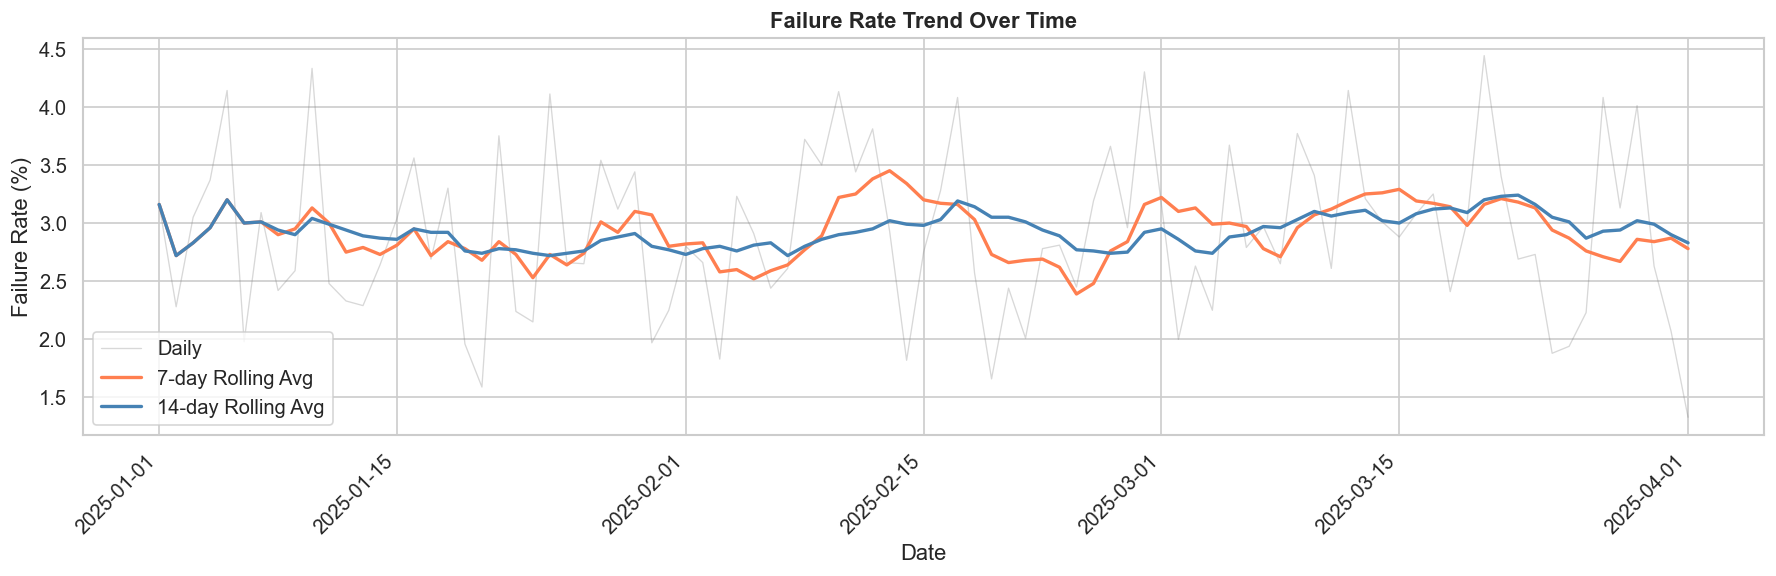

In [17]:
trends = trend_analysis.analyze(df)

daily = trends['daily']
rolling_7 = trends['rolling_7d']
rolling_14 = trends['rolling_14d']

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(daily.index, daily['Failure_Rate_Pct'], alpha=0.3, color='gray',
        label='Daily', linewidth=0.8)
ax.plot(rolling_7.index, rolling_7, color='coral',
        label='7-day Rolling Avg', linewidth=2)
ax.plot(rolling_14.index, rolling_14, color='steelblue',
        label='14-day Rolling Avg', linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Failure Rate (%)')
ax.set_title('Failure Rate Trend Over Time', fontweight='bold')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

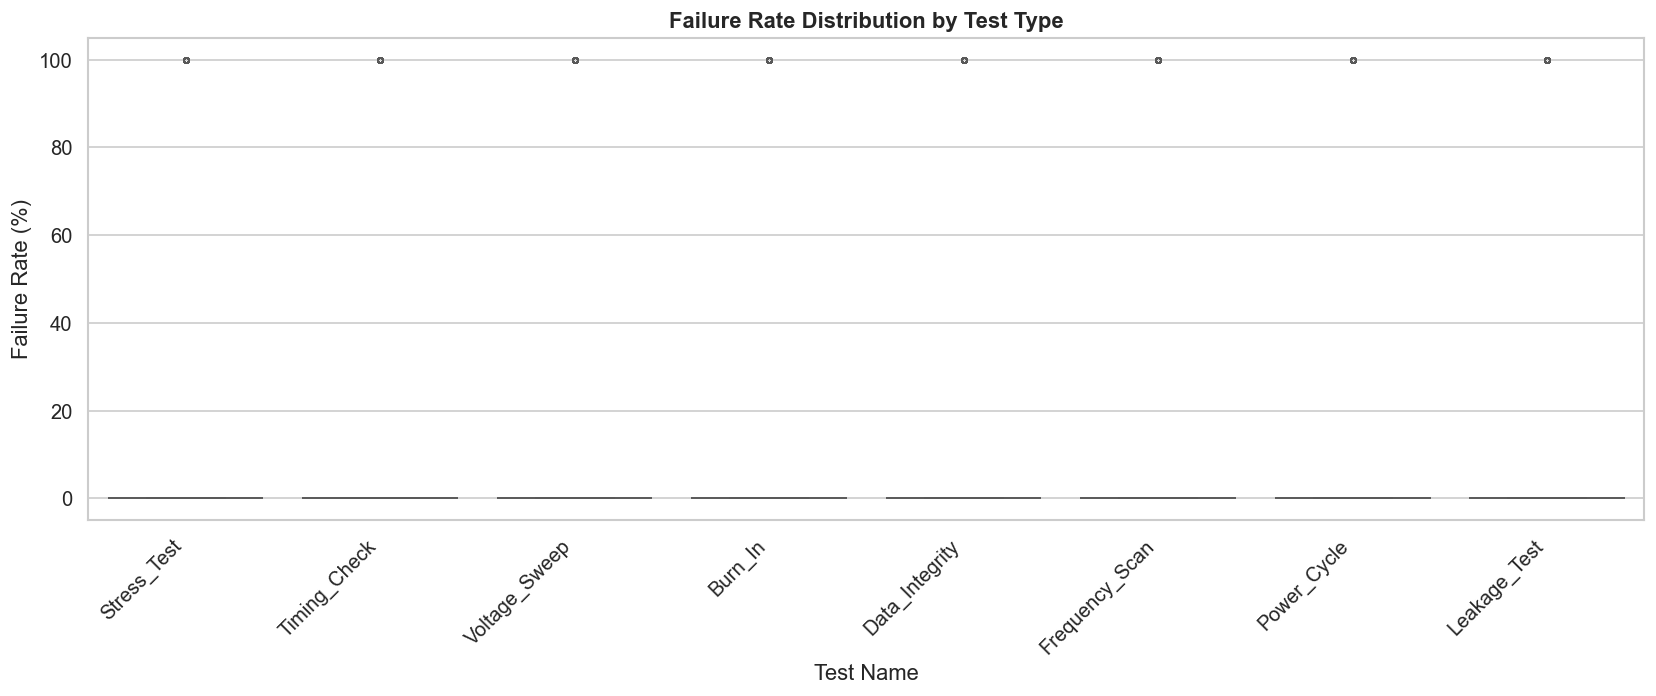

In [18]:
# Failure rate distribution by test type
device_test = df.groupby(['Device_ID', 'Test_Name'])['Result'].agg(
    lambda x: (x == 'FAIL').mean() * 100
).reset_index()
device_test.columns = ['Device_ID', 'Test_Name', 'Failure_Rate_Pct']

fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=device_test, x='Test_Name', y='Failure_Rate_Pct',
            hue='Test_Name', palette='Set2', fliersize=3, legend=False, ax=ax)
ax.set_xlabel('Test Name')
ax.set_ylabel('Failure Rate (%)')
ax.set_title('Failure Rate Distribution by Test Type', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## Step 7: Summary Report

Auto-generated engineering analysis with key findings and recommendations.

In [19]:
from src import report_generator

report_path = os.path.join(PROJECT_ROOT, 'output', 'reports', 'analysis_report.txt')
report_text = report_generator.generate_report(
    df, cleaning_report, failures, err_summary, cat_summary,
    patterns, anomaly_results, trends, report_path
)

print(report_text)


Report saved → /Users/york/Automated Test Log Analysis System/output/reports/analysis_report.txt
  AUTOMATED TEST LOG ANALYSIS REPORT
  Generated: 2026-02-05 18:37:22

  EXECUTIVE SUMMARY

  Total Test Records Analyzed : 54,367
  Unique Devices Tested       : 10,000
  Total Failures              : 1,586
  Overall Failure Rate         : 2.92%
  Date Range                   : 2025-01-01 to 2025-04-01
  Unique Test Types            : 8
  Unique Batches               : 25

  DATA QUALITY

  Rows with missing values     : 206
  Rows out of valid range      : 230
  Rows with bad timestamps     : 0
  Rows with invalid results    : 0
  Total rows removed           : 436
  Clean rows remaining         : 54,367

  TOP FAILURE ERROR CODES

  Error Code   Test               Category              Count  Avg Temp  Avg Volt
  --------------------------------------------------------------------------------
  ERR_T03      Timing_Check       Timing Failure          108     69.7°C    1.044V
  ERR_T02   

---
## Key Findings

| Finding | Detail |
|---------|--------|
| Highest failure test | **Timing_Check** (~4.7%) |
| Temperature effect | Failure rate jumps above 80°C |
| Anomalous batch | **Batch_17** (~8.7%, Z-Score > 4) |
| Top failure category | **Data Corruption** (~29%) |
| Outlier devices | 200+ flagged by Z-score |

### Recommendations
1. Targeted root cause analysis on Timing_Check failures
2. Thermal mitigation review for high-temperature test conditions
3. Process investigation for Batch_17 production lot
4. Continuous monitoring of temperature as primary failure correlate